In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold, \
    cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, \
    roc_auc_score, roc_curve, auc, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt

from data import Data
import warnings
warnings.filterwarnings('ignore')

In [2]:
def ml(data, spl):
    data = Data(f'{scale}')
    df = data.df

    # drop cr
    df = df[~df['is_careless_response']]

    print(df.label.value_counts())

    models = [LogisticRegression(random_state=42), xgb.XGBClassifier(random_state=42), MLPClassifier(random_state=42)]
    names = ['Logistic Regression', 'XGBoost', 'MLP']

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rus = RandomUnderSampler(random_state=42)


    X, y = df[[col for col in df.columns if col.startswith('time')]], df.label
    X, y = rus.fit_resample(X, y)

    result = {}

    print(f'Model,Accuracy,Recall,Precision,F1')
    for name, model in zip(names, models):
        print(name, end=',')
        y_proba = cross_val_predict(model, X, y, method='predict_proba')[:, 1]
        y_pred = cross_val_predict(model, X, y)
        acc = accuracy_score(y, y_pred)
        recall = recall_score(y, y_pred)
        prec = precision_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        print(round(acc, 3), end=',')
        print(round(recall, 3), end=',')
        print(round(prec, 3), end=',')
        print(round(f1, 3))
        result[name] = {'acc': acc, 'recall': recall, 'prec': prec, 'f1': f1, \
                        'y_real': y, 'y_pred': y_pred, 'y_proba': y_proba}


    
    return result

phq9
label
False    14741
True       329
Name: count, dtype: int64
Model,Accuracy,Recall,Precision,F1
Logistic Regression,0.705,0.641,0.735,0.685
XGBoost,0.682,0.663,0.69,0.676
MLP,0.698,0.669,0.71,0.689
gad7
label
False    15825
True       190
Name: count, dtype: int64
Model,Accuracy,Recall,Precision,F1
Logistic Regression,0.642,0.574,0.665,0.616
XGBoost,0.653,0.637,0.658,0.647
MLP,0.645,0.558,0.675,0.611
isi
label
False    18343
True       248
Name: count, dtype: int64
Model,Accuracy,Recall,Precision,F1
Logistic Regression,0.677,0.609,0.706,0.654
XGBoost,0.71,0.698,0.715,0.706
MLP,0.694,0.653,0.711,0.681
pss
label
False    6028
True      109
Name: count, dtype: int64
Model,Accuracy,Recall,Precision,F1
Logistic Regression,0.587,0.596,0.586,0.591
XGBoost,0.624,0.615,0.626,0.62
MLP,0.619,0.771,0.592,0.669


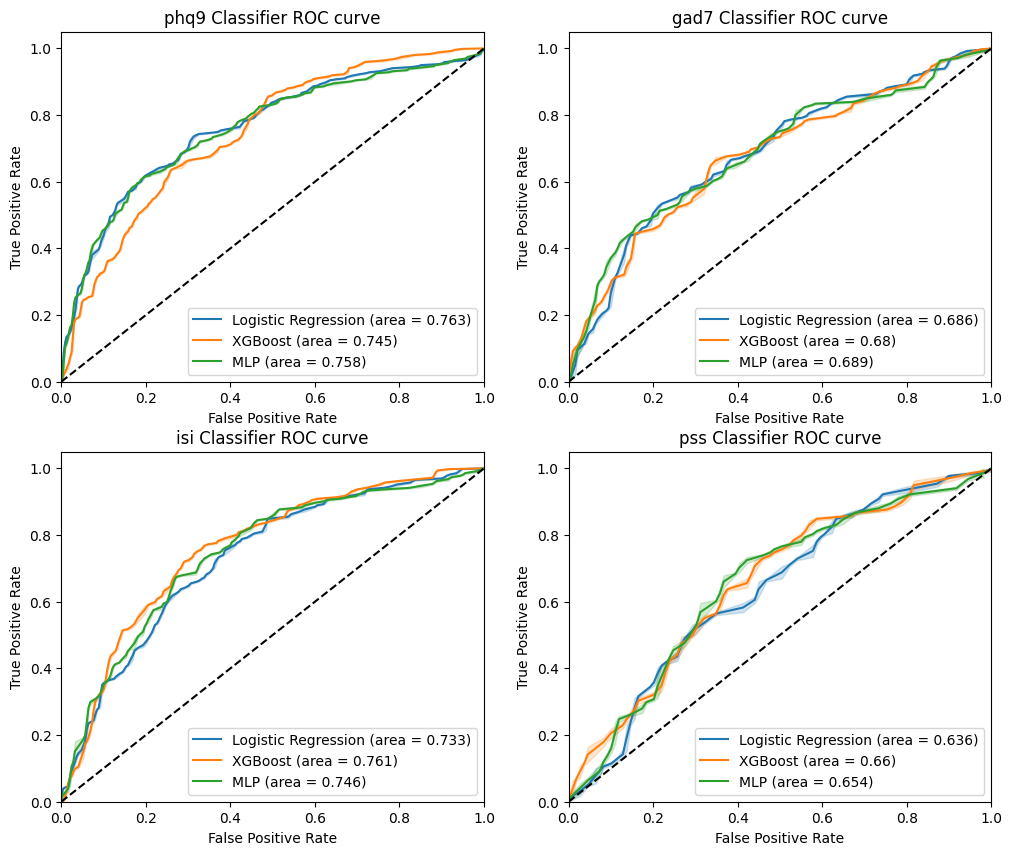

In [3]:
import pandas as pd
import numpy as np

def roc(result, scale, ax):
    for model_name in result.keys():

        # 确保y_real和y_proba中没有无穷大的值
        y_real = np.array(result[model_name]['y_real']).astype(float)
        y_proba = np.array(result[model_name]['y_proba']).astype(float)
        y_real = np.where(np.isinf(y_real), np.nan, y_real)
        y_proba = np.where(np.isinf(y_proba), np.nan, y_proba)


        fpr, tpr, thresholds = roc_curve(result[model_name]['y_real'], result[model_name]['y_proba'])
        df_plot = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'model': model_name})
        sns.lineplot(x='False Positive Rate', y='True Positive Rate', data=df_plot, ax=ax, label=f'{model_name} (area = {round(auc(fpr, tpr), 3)})')
    ax.plot([0, 1], [0, 1], 'k--')
    # x limit
    ax.set_xlim([0, 1.0])
    # y limit
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{scale} Classifier ROC curve')
    ax.legend(loc='lower right')

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flatten()

scales = ['phq9', 'gad7', 'isi', 'pss']
spls = [5, 5, 8, 29]

for i, (scale, spl) in enumerate(zip(scales, spls)):
    print(scale)
    result = ml(Data(scale), spl) 
    roc(result, scale, ax[i])

plt.show()